In [1]:
import os
import json
import numpy as np
import pandas as pd

base_dir = "results"
folders = [
    "Ablation-Remove-AugMeta",
    "Ablation-Remove-AugStruct",
    "Ablation-Remove-InfoCross",
    "Ablation-Remove-InfoIntro",
    "Ablation-Remove-Microbe",
    "Ablation-Remove-Gene",
    "OurModel",
]

metrics = ["AUC", "AUPR", "F1", "Precision", "Recall", "Accuracy"]
summary = {}

for folder in folders:
    records = {m: [] for m in metrics}
    for fold in range(1, 6):
        filepath = os.path.join(base_dir, folder, f"fold{fold}", "test_metrics.json")
        if os.path.exists(filepath):
            with open(filepath) as f:
                data = json.load(f)
            for m in metrics:
                records[m].append(data[m])
    # compute mean/std
    summary[folder] = {f"{m}_mean": np.mean(records[m]) if records[m] else None for m in metrics}
    summary[folder].update({f"{m}_std": np.std(records[m]) if records[m] else None for m in metrics})

df = pd.DataFrame(summary).T
os.makedirs(os.path.join(base_dir, "Ablation"), exist_ok=True)
out_path = os.path.join(base_dir, "Ablation", "ablation_summary.csv")
df.to_csv(out_path)
df


,AUC_mean,AUPR_mean,F1_mean,Precision_mean,Recall_mean,Accuracy_mean,AUC_std,AUPR_std,F1_std,Precision_std,Recall_std,Accuracy_std
Ablation-Remove-AugMeta,0.896152,0.857426,0.844523,0.785094,0.915248,0.832747,0.025090,0.028179,0.040575,0.024045,0.067114,0.038454
Ablation-Remove-AugStruct,0.912702,0.876026,0.871405,0.802808,0.953538,0.859131,0.012465,0.015279,0.008100,0.019304,0.015269,0.011268
Ablation-Remove-InfoCross,0.860053,0.817647,0.797452,0.759054,0.842472,0.788406,0.031365,0.032486,0.054797,0.031866,0.087157,0.049988
Ablation-Remove-InfoIntro,0.774474,0.733067,0.741277,0.719167,0.765953,0.733940,0.047621,0.042248,0.040280,0.026071,0.061527,0.037293
Ablation-Remove-Microbe,0.717478,0.680210,0.701761,0.689648,0.714857,0.695880,0.006419,0.005185,0.011486,0.024449,0.003484,0.017452
Ablation-Remove-Gene,0.723923,0.686177,0.706702,0.694434,0.719969,0.700932,0.003881,0.004122,0.010555,0.023248,0.006325,0.016075
OurModel,0.960272,0.946192,0.915933,0.875415,0.960569,0.911841,0.001181,0.002652,0.001441,0.007634,0.010262,0.001548


In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

RESULTS_DIR = "results"
EXPERIMENTS = [
    "Ablation-Remove-AugMeta",
    "Ablation-Remove-AugStruct",
    "Ablation-Remove-InfoCross",
    "Ablation-Remove-InfoIntro",
    "Ablation-Remove-Microbe",
    "Ablation-Remove-Gene",
    "OurModel"
]
OUTPUT_DIR = os.path.join(RESULTS_DIR, "Ablation", "figures")
os.makedirs(OUTPUT_DIR, exist_ok=True)


def load_fold_data(exp_dir):
    dfs, metrics = [], []
    for fold in range(1, 6):
        pred_path = os.path.join(RESULTS_DIR, exp_dir, f"fold{fold}", "test_pred.csv")
        metrics_path = os.path.join(RESULTS_DIR, exp_dir, f"fold{fold}", "test_metrics.json")
        dfs.append(pd.read_csv(pred_path))
        with open(metrics_path) as f:
            metrics.append(json.load(f))
    return pd.concat(dfs, ignore_index=True), metrics


def aggregate_metrics(metrics_list):
    metrics_df = pd.DataFrame(metrics_list)
    mean = metrics_df.mean()
    std = metrics_df.std()
    return {k: (mean[k], std[k]) for k in metrics_df.columns}


def plot_single_model(df, metrics, exp_name):
    y_true = df["label"].values
    y_pred = df["pred"].values
    y_prob = df["prob"].values

    auc_mean, auc_std = metrics["AUC"]
    aupr_mean, aupr_std = metrics["AUPR"]

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc_mean:.3f}±{auc_std:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {exp_name}")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{exp_name}_ROC.png"), dpi=300)
    plt.close()

    # PR
    recall, precision, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision, label=f"AUPR={aupr_mean:.3f}±{aupr_std:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve - {exp_name}")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{exp_name}_PR.png"), dpi=300)
    plt.close()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix (Counts) - {exp_name}")
    plt.savefig(os.path.join(OUTPUT_DIR, f"{exp_name}_CM.png"), dpi=300)
    plt.close()

    # Confusion Matrix
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
    disp.plot(cmap="Blues", values_format=".2f")
    plt.title(f"Confusion Matrix (Proportion) - {exp_name}")
    plt.savefig(os.path.join(OUTPUT_DIR, f"{exp_name}_CM_norm.png"), dpi=300)
    plt.close()

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    return fpr, tpr, recall, precision, (auc_mean, auc_std), (aupr_mean, aupr_std), (prob_pred, prob_true)


if __name__ == "__main__":
    roc_curves, pr_curves, calib_curves = {}, {}, {}

    metrics_summary = {}

    for exp in EXPERIMENTS:
        df, metrics_list = load_fold_data(exp)
        metrics = aggregate_metrics(metrics_list)
        metrics_summary[exp] = metrics

        fpr, tpr, recall, precision, auc_stats, aupr_stats, calib = plot_single_model(df, metrics, exp)
        roc_curves[exp] = (fpr, tpr, auc_stats)
        pr_curves[exp] = (recall, precision, aupr_stats)
        calib_curves[exp] = calib

    plt.figure(figsize=(10, 8))
    for exp, (fpr, tpr, (auc_mean, auc_std)) in roc_curves.items():
        plt.plot(fpr, tpr, label=f"{exp} (AUC={auc_mean:.3f}±{auc_std:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - All Models")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, "All_ROC.pdf"))
    plt.close()

    plt.figure(figsize=(10, 8))
    for exp, (recall, precision, (aupr_mean, aupr_std)) in pr_curves.items():
        plt.plot(recall, precision, label=f"{exp} (AUPR={aupr_mean:.3f}±{aupr_std:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PR Curves - All Models")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, "All_PR.pdf"))
    plt.close()

    # plt.figure(figsize=(12, 8))
    for exp, (prob_pred, prob_true) in calib_curves.items():
        plt.plot(prob_pred, prob_true, marker="o", label=exp)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Predicted probability")
    plt.ylabel("True probability in bin")
    plt.title("Calibration Curves - All Models")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, "All_Calib.pdf"))
    plt.close()
    df_out = pd.DataFrame({
        exp: {k: f"{v[0]:.3f}±{v[1]:.3f}" for k, v in metrics.items()}
        for exp, metrics in metrics_summary.items()
    }).T
    df_out.to_csv(os.path.join(OUTPUT_DIR, "metrics_summary.csv"))


In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

RESULTS_DIR = "results"
EXPERIMENTS = [
    "OtherModel-AMDGT",
    "OtherModel-AdaDR",
    "OtherModel-CompGCN",
    "OtherModel-DRHGCN",
    # "OtherModel-GAT",
    "OtherModel-HGT",
    "OtherModel-MCHNN", 
    "OtherModel-MILGNet",
    "OtherModel-REDDA", 
    "OtherModel-RGCN",
    "OurModel"
]
OUTPUT_DIR = os.path.join(RESULTS_DIR, "Compared")
os.makedirs(OUTPUT_DIR, exist_ok=True)


def load_fold_data(exp_dir):
    dfs, metrics = [], []
    for fold in range(1, 6):
        pred_path = os.path.join(RESULTS_DIR, exp_dir, f"fold{fold}", "test_pred.csv")
        metrics_path = os.path.join(RESULTS_DIR, exp_dir, f"fold{fold}", "test_metrics.json")
        dfs.append(pd.read_csv(pred_path))
        with open(metrics_path) as f:
            metrics.append(json.load(f))
    return pd.concat(dfs, ignore_index=True), metrics


def aggregate_metrics(metrics_list):
    metrics_df = pd.DataFrame(metrics_list)
    mean = metrics_df.mean()
    std = metrics_df.std()
    return {k: (mean[k], std[k]) for k in metrics_df.columns}


def plot_single_model(df, metrics, exp_name):
    y_true = df["label"].values
    y_pred = df["pred"].values
    y_prob = df["prob"].values

    auc_mean, auc_std = metrics["AUC"]
    aupr_mean, aupr_std = metrics["AUPR"]

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc_mean:.3f}±{auc_std:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {exp_name}")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{exp_name}_ROC.png"), dpi=300)
    plt.close()

    # PR
    recall, precision, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision, label=f"AUPR={aupr_mean:.3f}±{aupr_std:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve - {exp_name}")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{exp_name}_PR.png"), dpi=300)
    plt.close()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix (Counts) - {exp_name}")
    plt.savefig(os.path.join(OUTPUT_DIR, f"{exp_name}_CM.png"), dpi=300)
    plt.close()

    # Confusion Matrix
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
    disp.plot(cmap="Blues", values_format=".2f")
    plt.title(f"Confusion Matrix (Proportion) - {exp_name}")
    plt.savefig(os.path.join(OUTPUT_DIR, f"{exp_name}_CM_norm.png"), dpi=300)
    plt.close()

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    return fpr, tpr, recall, precision, (auc_mean, auc_std), (aupr_mean, aupr_std), (prob_pred, prob_true)


if __name__ == "__main__":
    roc_curves, pr_curves, calib_curves = {}, {}, {}

    metrics_summary = {}

    for exp in EXPERIMENTS:
        df, metrics_list = load_fold_data(exp)
        metrics = aggregate_metrics(metrics_list)
        metrics_summary[exp] = metrics

        fpr, tpr, recall, precision, auc_stats, aupr_stats, calib = plot_single_model(df, metrics, exp)
        roc_curves[exp] = (fpr, tpr, auc_stats)
        pr_curves[exp] = (recall, precision, aupr_stats)
        calib_curves[exp] = calib

    plt.figure(figsize=(10, 8))
    for exp, (fpr, tpr, (auc_mean, auc_std)) in roc_curves.items():
        plt.plot(fpr, tpr, label=f"{exp} (AUC={auc_mean:.3f}±{auc_std:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - All Models")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, "All_ROC.pdf"))
    plt.close()

    plt.figure(figsize=(10, 8))
    for exp, (recall, precision, (aupr_mean, aupr_std)) in pr_curves.items():
        plt.plot(recall, precision, label=f"{exp} (AUPR={aupr_mean:.3f}±{aupr_std:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PR Curves - All Models")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, "All_PR.pdf"))
    plt.close()

    plt.figure()
    for exp, (prob_pred, prob_true) in calib_curves.items():
        plt.plot(prob_pred, prob_true, marker="o", label=exp)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Predicted probability")
    plt.ylabel("True probability in bin")
    plt.title("Calibration Curves - All Models")
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, "All_Calib.pdf"))
    plt.close()
    df_out = pd.DataFrame({
        exp: {k: f"{v[0]:.3f}±{v[1]:.3f}" for k, v in metrics.items()}
        for exp, metrics in metrics_summary.items()
    }).T
    df_out.to_csv(os.path.join(OUTPUT_DIR, "metrics_summary.csv"))

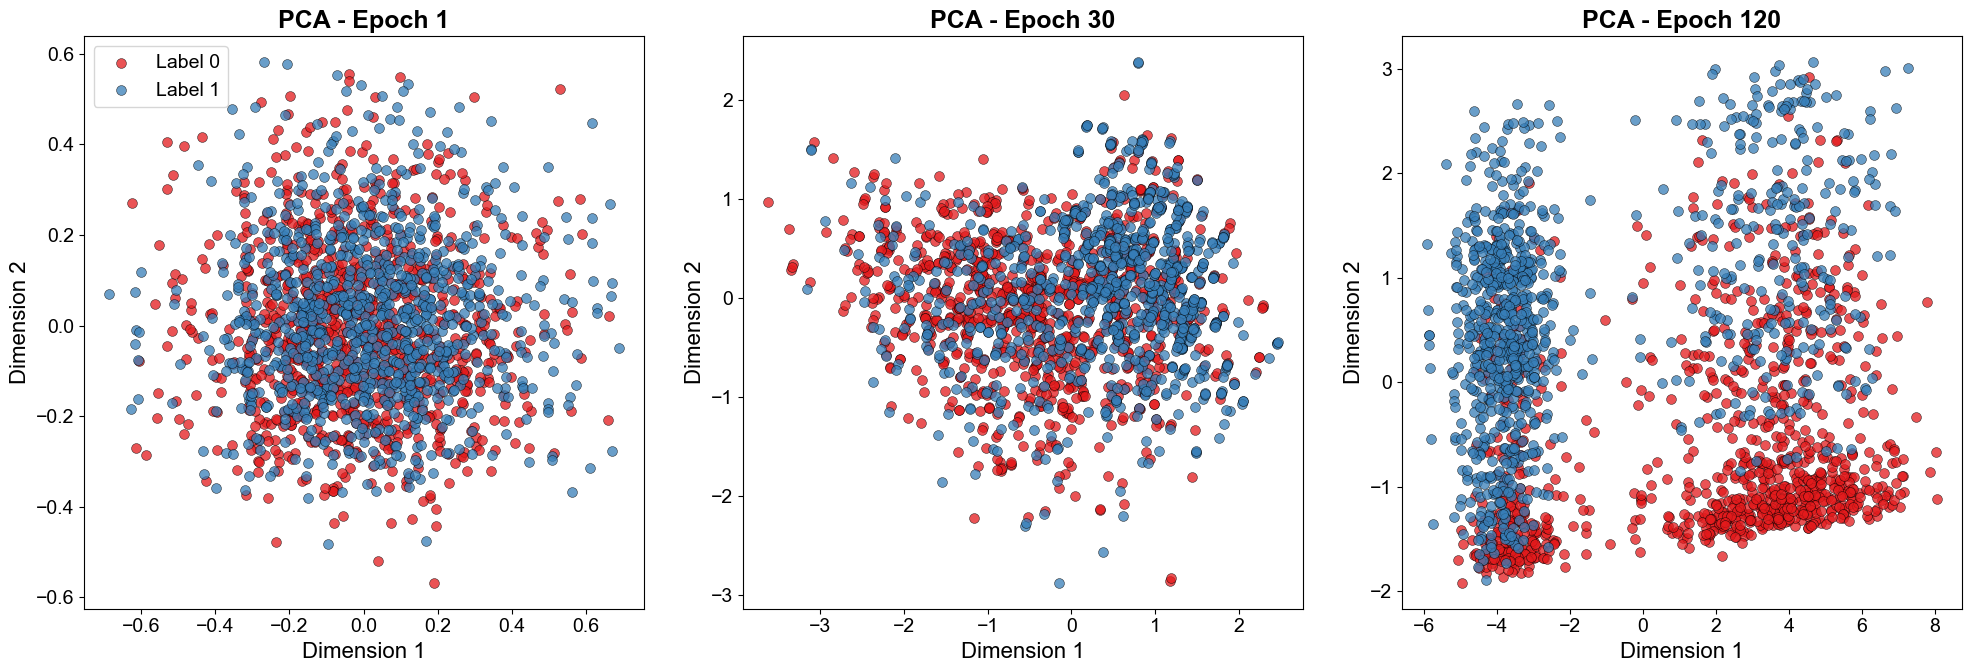

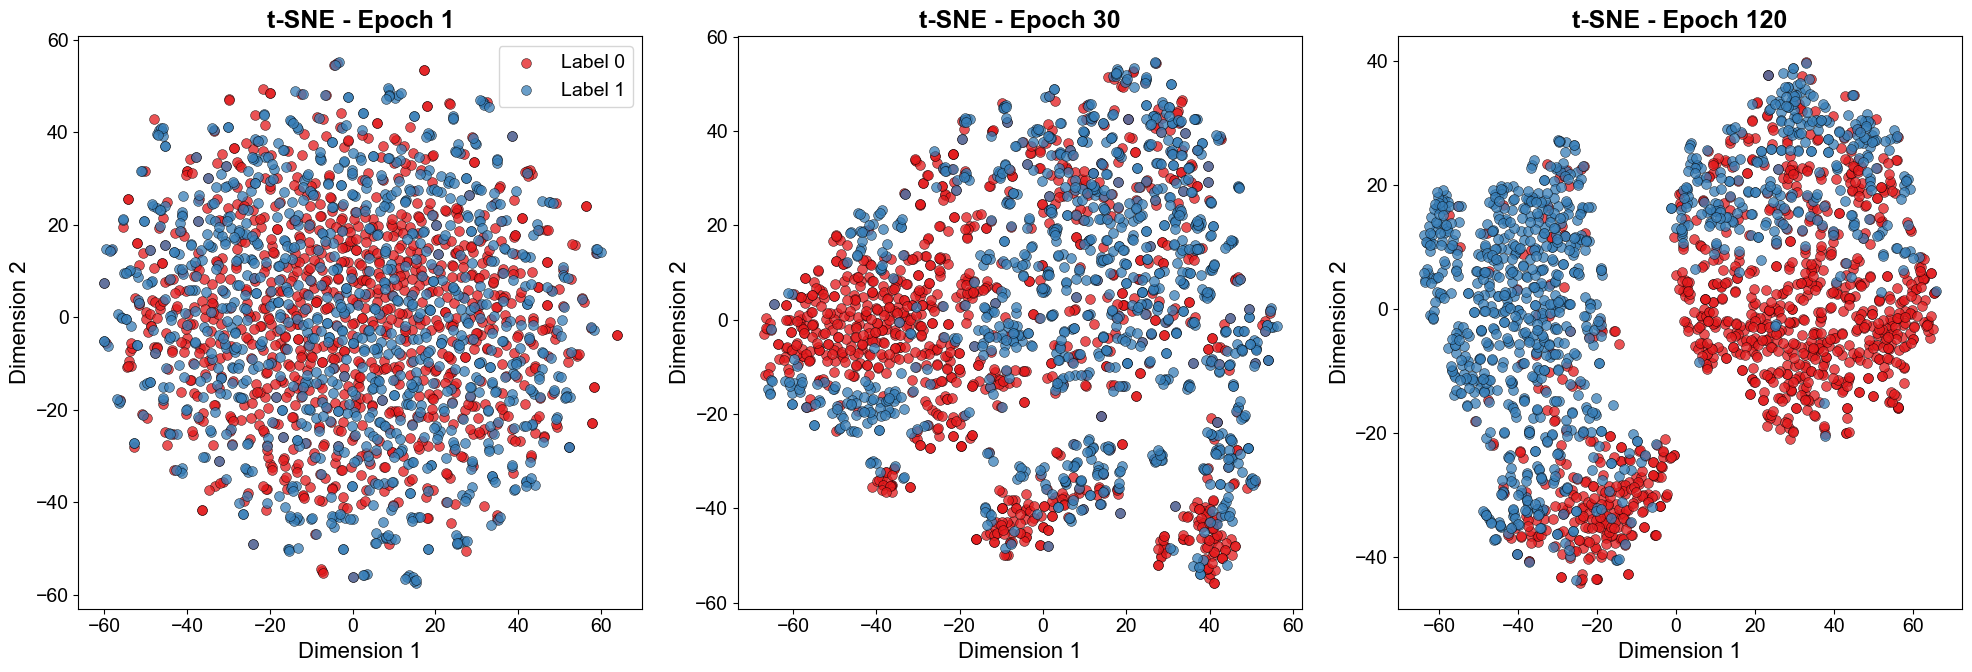

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16 
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

base_dir = "results/OurModel/fold1/embeddings"
save_dir = "results/Embedding"
os.makedirs(save_dir, exist_ok=True)

epochs = [1, 30, 120]
labels = [0, 1]
palette = plt.cm.Set1.colors
colors = {0: palette[0], 1: palette[1]}

def load_embeddings(epoch, labels, sample_size=1000):
    embs, lbls = [], []
    for label in labels:
        file_path = os.path.join(base_dir, f"epoch{epoch}_label{label}.npy")
        emb = np.load(file_path)
        if emb.shape[0] > sample_size:
            idx = np.random.choice(emb.shape[0], sample_size, replace=False)
            emb = emb[idx]
        embs.append(emb)
        lbls.append(np.full(emb.shape[0], label))
    embs = np.vstack(embs)
    lbls = np.concatenate(lbls)
    return embs, lbls

def plot_embeddings(method_name, reducer, epochs, labels):
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    for idx, epoch in enumerate(epochs):
        X, y = load_embeddings(epoch, labels)
        X_2d = reducer.fit_transform(X)
        ax = axes[idx]
        for label in np.unique(y):
            ax.scatter(
                X_2d[y == label, 0], X_2d[y == label, 1],
                s=50, c=[colors[label]], alpha=0.75,
                label=f"Label {label}" if idx == 0 else None,
                edgecolor="k", linewidth=0.4
            )
        ax.set_title(f"{method_name} - Epoch {epoch}", fontweight="bold")
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
    axes[0].legend()
    plt.tight_layout()
    out_path = os.path.join(save_dir, f"{method_name}_embedding.png")

    plt.savefig(out_path, dpi=800, bbox_inches="tight")
    plt.show()

plot_embeddings("PCA", PCA(n_components=2), epochs, labels)
plot_embeddings("t-SNE", TSNE(n_components=2, random_state=42, perplexity=30), epochs, labels)
